### Calculate PixelPerMetric Ratio

##### Import dependencies

In [296]:
from scipy.spatial import distance as dist
from matplotlib import pyplot as plt
from imutils import perspective
from imutils import contours
import imutils
import numpy as np
import math
import cv2

##### Function to compute midpoint from two points

In [297]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [298]:
image_path_red = "Images/RBC.png"


In [299]:
image = cv2.imread(image_path_red)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)




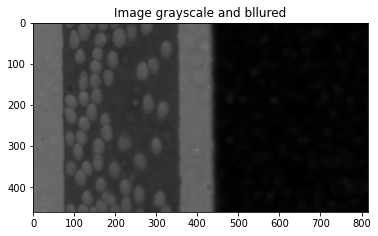

In [300]:
# show in notebook
gray_show = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
plt.imshow(gray_show)
plt.title("Image grayscale and bllured")
plt.show()

##### Canny edge detection

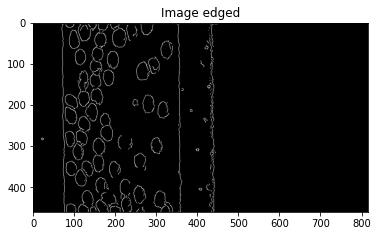

In [301]:
edged = cv2.Canny(gray, 10, 30, None, 3)
cv2.imwrite('Edged_image.png', edged) 

edged_show = cv2.cvtColor(edged, cv2.COLOR_GRAY2RGB)

plt.imshow(edged_show)
plt.title("Image edged")
plt.show()

In [302]:
edged_BGR = cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR)



##### Line detection
https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

In [303]:
lines = cv2.HoughLinesP(edged, 1, np.pi / 180, 10, None, 50, 10)


In [304]:

if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            cv2.line(edged_BGR, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
            
print(lines)


cv2.imshow("Lines", edged_BGR)
cv2.waitKey(0)
cv2.destroyAllWindows()

[[[  0   1 449   1]]

 [[356 223 356 143]]

 [[440 458 440 401]]

 [[436  83 437 146]]

 [[ 75 372  76 422]]

 [[434  97 434  43]]

 [[439 344 439 282]]

 [[356  70 357 120]]

 [[356 256 357 319]]]


##### 9 Lines have been identified, where there is minimum one line on each side of the channel (Kanal)
##### The channel has a known width of 50ym
##### A line consists of two points: the starting point (x1, y1) and the end point (x2, y2)

##### with the starting point of the line from the left edge A1 (75, 372) and the end point A2 (76,422) it is possible to calculate the difference in the x-axis of the image with the second line from the right edge with B1 (356, 223) and B2 (356, 143). This difference will be the reference length to calculate the pixel per metric ratio of this image: 

##### Pixel length: 356-75 =281 pixels
##### Known Length: 50ym
##### pixel per metric ratio: 281 / 50 = 5.62 pixels/ym

In [305]:
a = lines[1][0][0]
b = lines[4][0][0]
pixels = a-b
width = 50 #ym
pixelsPerMetric = pixels / width
print(pixelsPerMetric)


5.62


### Detecting and measuring Red blood cells

In [306]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [307]:

for c in cnts:
    if cv2.contourArea(c) <10:
        continue

    #print(cv2.contourArea(c))
    orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)
    
    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 1, (0, 0, 255), -1)

	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

	# draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 1, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 1, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 1, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 1, (255, 0, 0), -1)

	# draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 1)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 1)

	# compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

	# compute the pixel/perMetric as the ratio of pixels to supplied metric
	# (in this case, cm)
	
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / width

	# compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric

	# draw the object sizes on the image
    cv2.putText(orig, "{:.1f}ym".format(dimB),
		(int(tltrX - 15), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 1)
    cv2.putText(orig, "{:.1f}ym".format(dimA),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 1)
	
	



    cv2.imshow("Image", orig)
    cv2.waitKey(0)

cv2.destroyAllWindows()

##### Some blood cells weren't able to be detected proparly by the program, but some RBC are well detected and the with and height could be measured. 

##### Trying to fill in the gaps by further preprocessing the edged image with dilation and morphological transformation,slightly improved the detection of single RBCs

https://docs.opencv.org/3.4/d4/d76/tutorial_js_morphological_ops.html

In [308]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
dilated = cv2.dilate(edged, kernel)
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [309]:

for c in cnts:
    if cv2.contourArea(c) <100:
        continue

    #print(cv2.contourArea(c))
    orig = image.copy()
    orig2 = orig.copy()
    box = cv2.minAreaRect(c)
    box = cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    

    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)
    
    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 1, (0, 0, 255), -1)

	# unpack the ordered bounding box, then compute the midpoint
	# between the top-left and top-right coordinates, followed by
	# the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

	# draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 1, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 1, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 1, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 1, (255, 0, 0), -1)

	# draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 1)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 1)

	# compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

	# compute the pixel/perMetric as the ratio of pixels to supplied metric
	# (in this case, cm)
	
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / width

	# compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric

	# draw the object sizes on the image
    cv2.putText(orig, "{:.1f}ym".format(dimB),
		(int(tltrX - 15), int(tltrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 1)
    cv2.putText(orig, "{:.1f}ym".format(dimA),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 1)
	
	



    cv2.imshow("Image", orig)
    cv2.waitKey(0)

cv2.destroyAllWindows()

### Cropping and adaptive thresholding

##### Trying to detect edges better by cropping out a well detected RBC and applying adaptive thresholding
##### In the future an algorithm could be developed which automatically can classify which detected contours are actually single RBCs

##### for now this decision was made manually

True

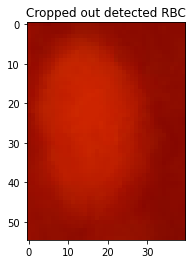

In [310]:
[X, Y, W, H] = cv2.boundingRect(cnts[4]) # 4=> manually identified contours box which has a single rbc in it
a = 5
cropped_image = image[Y:Y+H+a, X:X+W+a]
cropped_image_show = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_image_show)
plt.title("Cropped out detected RBC")
cv2.imwrite('cropped_RBC.png', cropped_image)

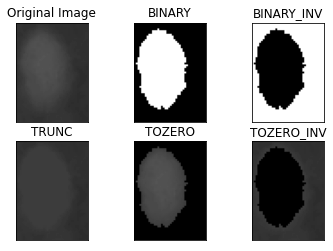

In [311]:
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
a= 60
img = cv.imread('cropped_RBC.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
ret,thresh1 = cv.threshold(img,a,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,a,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,a,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,a,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,a,255,cv.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

##### WIth the help of cropping and adaptive thresholding it was possible to focus on one single RBC. With the binary image generated,it would be theoreticaly possible to generate some sort of a topographical depth map, as explained in the report, if more informations would be available of this specific cell.


### Optimized detection method

In [338]:
"""
implementation of linear stretching and gamma
http://spatial-analyst.net/ILWIS/htm/ilwisapp/stretch_algorithm.htm
"""

import cv2
import numpy as np


def linear_stretching(input, lower_stretch_from, upper_stretch_from):
    """
    Linear stretching of input pixels
    :param input: integer, the input value of pixel that needs to be stretched
    :param lower_stretch_from: lower value of stretch from range - input
    :param upper_stretch_from: upper value of stretch from range - input
    :return: integer, integer, the final stretched value
    """

    lower_stretch_to = 0 # lower value of the range to stretch to - output
    upper_stretch_to = 255  # upper value of the range to stretch to - output

    output = (input - lower_stretch_from) * ((upper_stretch_to - lower_stretch_to) / (upper_stretch_from - lower_stretch_from)) + lower_stretch_to

    return output


def gamma_correction():
    """
    Restore the contrast in the faded image using linear stretching.
    """
    # imports the image of the moon
    moon = cv2.imread('Images/RBC.png', 0)

    # assign variable to max and min value of image pixels
    max_value = np.max(moon)
    min_value = np.min(moon)

    # cycle to apply linear stretching formula on each pixel
    for y in range(len(moon)):
        for x in range(len(moon[y])):
            moon[y][x] = linear_stretching(moon[y][x], min_value, max_value)

    # writes out the resulting restored picture
    cv2.imwrite('gamma.png', moon)

gamma_correction()